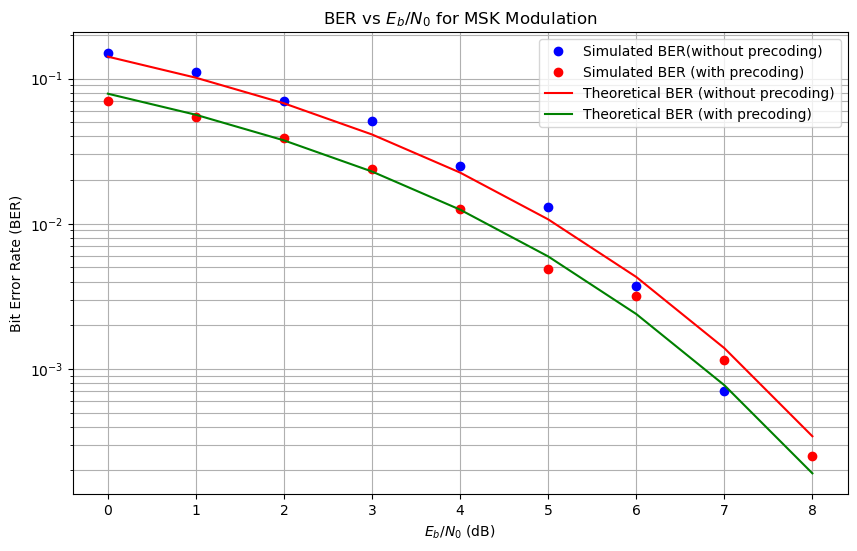

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import upfirdn, firwin2, lfilter, welch
from scipy.special import erfc
from numpy import sqrt
import random

# Define AWGN function to simulate noise
def awgn(signal, SNR):
    snr_linear = 10 ** (SNR / 10)
    signal_power = np.mean(signal ** 2)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power) * np.random.normal(size=signal.shape)
    return signal + noise

# The MSK error function remains the same
def msk_errors(Nbits, nsamp, EbNo):
    n = Nbits  # number of data bits
    R = 2000000  # bit rate
    fc = 8000000  # carrier frequency
    ns = nsamp  # oversampling factor

    # AWGN channel
    SNR = EbNo - 10 * np.log10(ns/2)  # in dB
    T = 1 / R  # 1-bit period (= basic period)
    Ts = T / ns  # sampling frequency
    fss = 1/Ts

    # Input sequence
    y = np.concatenate(([1], np.sign(np.random.rand(n - 1) - 0.5)))  # random numbers, -1 or 1
    x = y

    g = np.ones(ns)
    xx = upfirdn(g, x, up=ns)  # NRZ polar pulse train samples

    # Time grid
    ts = np.arange(0, len(xx) * Ts, Ts)  # of length ns*(n+1)

    ## MSK TRANSMITTER
    xs = xx
    theta = np.cumsum(xs) * np.pi / 2 / ns
    xs_i = np.cos(theta)  # in-phase component
    xs_q = np.sin(theta)  # quadrature component

    # Ensure that xs_i and xs_q are the same length as the time grid `ts`
    if len(xs_i) > len(ts):
        xs_i = xs_i[:len(ts)]
        xs_q = xs_q[:len(ts)]
    elif len(ts) > len(xs_i):
        ts = ts[:len(xs_i)]

    # Modulation
    s = xs_i * np.cos(2 * np.pi * fc * ts) - xs_q * np.sin(2 * np.pi * fc * ts)

    # Addition of noise
    s = awgn(s, SNR)

    ## MSK RECEIVER
    xs_i = s * np.cos(2 * np.pi * fc * ts)
    xs_q = -s * np.sin(2 * np.pi * fc * ts)

    # LP (Parks-McClellan) filter
    f1 = 0.75*(fss/2)/ns
    f2 = 4*f1
    order = 8 * ns
    fpts = [0, f1, f2, fss/2]
    mag = [1, 1, 0, 0]
    wt = [1, 1]
    b = firwin2(order+1, fpts, mag, fs=fss)
    a = 1

    len_xs_i = len(xs_i)
    dummy = np.concatenate((xs_i, np.zeros(order)))
    dummy1 = lfilter(b, a, dummy)
    delay = order // 2
    xs_i = dummy1[delay:delay + len_xs_i]
    xs_i = np.concatenate((xs_i, np.ones(nsamp-1)))

    dummy = np.concatenate((xs_q, np.zeros(order)))
    dummy1 = lfilter(b, a, dummy)
    xs_q = dummy1[delay:delay + len_xs_i]

    bi = 1
    xr_1 = 1
    xr = np.zeros(n)
    for k in range(0, n, 2):
        li = np.arange((k+1) * ns, min((k + 3) * ns-1, len(xs_i)))
        lq = np.arange(k * ns, min((k + 2) * ns-1, len(xs_q)))
        xi = xs_i[li]
        xq = xs_q[lq]
        gmi = np.cos(np.pi / 2 / T * Ts * li)  # matched-filter pulse
        gmq = -gmi  # =sin(pi/2/T*Ts*lq);
        bi_1 = bi
        bi = np.sign(np.sum(xi * gmi))
        bq = np.sign(np.sum(xq * gmq))
        xr[k] = bi_1 * bq
        xr[k+1] = bi * bq
        xr_1 = xr[k + 1]

    xr = xr.reshape(-1)
    err = np.not_equal(x, xr)
    errors = np.sum(err)
    return errors / Nbits

# The MSK error function remains the same
def msk_errors_precoding(Nbits, nsamp, EbNo):
    n = Nbits  # number of data bits
    R = 2000000  # bit rate
    fc = 8000000  # carrier frequency
    ns = nsamp  # oversampling factor

    # AWGN channel
    SNR = EbNo - 10 * np.log10(ns/2)  # in dB
    T = 1 / R  # 1-bit period (= basic period)
    Ts = T / ns  # sampling frequency
    fss = 1/Ts

    # Input sequence
    y = np.concatenate(([1], np.sign(np.random.rand(n - 1) - 0.5)))  # random numbers, -1 or 1
    x = y
    x[0] = 1
    for i in range(1, len(y)):
        x[i] = y[i] * x[i-1]  # Apply precoding rule

        

    g = np.ones(ns)
    xx = upfirdn(g, x, up=ns)  # NRZ polar pulse train samples

    # Time grid
    ts = np.arange(0, len(xx) * Ts, Ts)  # of length ns*(n+1)

    ## MSK TRANSMITTER
    xs = xx
    theta = np.cumsum(xs) * np.pi / 2 / ns
    xs_i = np.cos(theta)  # in-phase component
    xs_q = np.sin(theta)  # quadrature component

    # Ensure that xs_i and xs_q are the same length as the time grid ts
    if len(xs_i) > len(ts):
        xs_i = xs_i[:len(ts)]
        xs_q = xs_q[:len(ts)]
    elif len(ts) > len(xs_i):
        ts = ts[:len(xs_i)]

    # Modulation
    s = xs_i * np.cos(2 * np.pi * fc * ts) - xs_q * np.sin(2 * np.pi * fc * ts)

    # Addition of noise
    s = awgn(s, SNR)

    ## MSK RECEIVER
    xs_i = s * np.cos(2 * np.pi * fc * ts)
    xs_q = -s * np.sin(2 * np.pi * fc * ts)

    # LP (Parks-McClellan) filter
    f1 = 0.75*(fss/2)/ns
    f2 = 4*f1
    order = 8 * ns
    fpts = [0, f1, f2, fss/2]
    mag = [1, 1, 0, 0]
    wt = [1, 1]
    b = firwin2(order+1, fpts, mag, fs=fss)
    a = 1

    len_xs_i = len(xs_i)
    dummy = np.concatenate((xs_i, np.zeros(order)))
    dummy1 = lfilter(b, a, dummy)
    delay = order // 2
    xs_i = dummy1[delay:delay + len_xs_i]
    xs_i = np.concatenate((xs_i, np.ones(nsamp-1)))

    dummy = np.concatenate((xs_q, np.zeros(order)))
    dummy1 = lfilter(b, a, dummy)
    xs_q = dummy1[delay:delay + len_xs_i]

    # Updated MSK decoding for precoded bits with recursive logic
    bi = 1
    xr_1 = 1  # Initialize previous decoded bit (xr_1)
    xr = np.zeros(n)  # Array to store decoded bits

    for k in range(0, n, 2):
        li = np.arange((k+1) * ns, min((k + 3) * ns-1, len(xs_i)))
        lq = np.arange(k * ns, min((k + 2) * ns-1, len(xs_q)))
        xi = xs_i[li]
        xq = xs_q[lq]
        
        # Matched filter output (to match MSK modulation characteristics)
        gmi = np.cos(np.pi / 2 / T * Ts * li)  # In-phase matched filter pulse
        gmq = -gmi  # Quadrature matched-filter pulse (sin is negative of cosine)
        
        # Save previous in-phase matched filter output
        bi_1 = bi
        
        # Decode in-phase (I) and quadrature (Q) components
        bi = np.sign(np.sum(xi * gmi))
        bq = np.sign(np.sum(xq * gmq))
        
        # Apply recursive decoding rule for precoded MSK
        xr[k] = bi_1 * bq  # Decode the k-th bit
        xr[k+1] = bi * bq  # Decode the (k+1)-th bit
        
        # Update the previously decoded bit (xr_1)
        xr_1 = xr[k+1]

    xr = xr.reshape(-1)
    err = np.not_equal(y, xr)
    errors = np.sum(err)
    return 0.5*errors / Nbits

# Simulate BER for different Eb/No values and plot only the dots for simulation
EbNo_range = np.arange(0, 9, 1)  # EbNo from 0 to 10 dB
Nbits = 10000  # Increase number of bits to reduce variance
nsamp = 32

simulated_BER = []
simulated_BER_precoding=[]
theoretical_BER = []
theoretical_BER_precoded = []

for EbNo in EbNo_range:
    sim_BER = msk_errors(Nbits, nsamp, EbNo)
    sim_BER1= msk_errors_precoding(Nbits, nsamp, EbNo)
    theoretical_BER_value = 0.9 * erfc(sqrt(10**(EbNo / 10)))  # without precoding
    theoretical_BER_precoded_value = erfc(sqrt(10**(EbNo / 10))) / 2  # with precoding
    
    simulated_BER.append(sim_BER)
    simulated_BER_precoding.append(sim_BER1)
    theoretical_BER.append(theoretical_BER_value)
    theoretical_BER_precoded.append(theoretical_BER_precoded_value)

# Plot the results
plt.figure(figsize=(10, 6))
plt.semilogy(EbNo_range, simulated_BER, 'bo', label='Simulated BER(without precoding)')  # Dots only for simulation
plt.semilogy(EbNo_range, simulated_BER_precoding, 'ro', label='Simulated BER (with precoding)')  # Dots only for simulation
plt.semilogy(EbNo_range, theoretical_BER, 'r-', label='Theoretical BER (without precoding)')
plt.semilogy(EbNo_range, theoretical_BER_precoded, 'g-', label='Theoretical BER (with precoding)')
plt.xlabel('$E_b/N_0$ (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('BER vs $E_b/N_0$ for MSK Modulation')
plt.legend()
plt.grid(True, which='both')
plt.show()
